## Load Irradiance

From header, 
```
ALLSKY_KT              CERES SYN1deg All Sky Insolation Clearness Index (dimensionless) 
ALLSKY_SRF_ALB         CERES SYN1deg All Sky Surface Albedo (dimensionless) 
SZA                    CERES SYN1deg Solar Zenith Angle (Degrees) 
ALLSKY_SFC_PAR_TOT     CERES SYN1deg All Sky Surface PAR Total (W/m^2) 
CLRSKY_SFC_SW_DWN      CERES SYN1deg Clear Sky Surface Shortwave Downward Irradiance (Wh/m^2) 
```

Further Reading at [NASA Source](https://power.larc.nasa.gov/docs/methodology/energy-fluxes/derived-parameters/).

**PAR** : Photosynthetically Active Radiation (PAR)

In [84]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
from datetime import datetime

import pvlib
from pvlib.location import Location

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

In [85]:
# Load Irradiance
dataPath = Path('./data')
fileName = 'POWER_Point_Hourly.csv'
df = pd.read_csv(dataPath / fileName,  skiprows=13)
df['MO'] = df['MO'].astype(str).str.zfill(2)
df['DY'] = df['DY'].astype(str).str.zfill(2)
df['HR'] = df['HR'].astype(str).str.zfill(2)
df['date'] = df['YEAR'].astype(str) + ' ' + df['MO'] + ' ' + df['DY'] + ' ' + df['HR']
df['date'] = pd.to_datetime(df['date'], format='%Y %m %d %H')

# subset
df = df[['date', 'ALLSKY_KT', 'ALLSKY_SRF_ALB', 'SZA', 'ALLSKY_SFC_PAR_TOT', 'CLRSKY_SFC_SW_DWN']]

# Convert Datetime
df.tail()

# Y : CLRSKY_SFC_SW_DWN or ALLSKY_SFC_PAR_TOT
df_Y = df

# check visually
df_Y.head(2)

,date,ALLSKY_KT,ALLSKY_SRF_ALB,SZA,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_SW_DWN
0,2020-12-31 18:00:00,-999.0,-999.0,-999.0,0.0,0.0
1,2020-12-31 19:00:00,-999.0,-999.0,-999.0,0.0,0.0


## Load CFSv2 Data

In [86]:
# load / process
CFSv2_list = [dataPath / file for file in os.listdir('./data') if file.startswith('CFSV2')]
df_list = []
for fileLoc in CFSv2_list:
    df = pd.read_csv(fileLoc)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d_%H_%M')
    colName = str(fileLoc).split('_')[1].split('.')[0]
    df = df.rename(columns = {'value' : colName})
    
    df_list.append(df)
    
    del df
    
# fuse dataframes
df_all = None
for df_loc in df_list:
    df_loc = df_loc.groupby('date', as_index=False).mean()
    if(df_all is None):
        df_all = df_loc
    else:
        df_all = pd.merge(left=df_all, right=df_loc, on='date', how='inner')

# rename
df_CFSv2 = df_all

# check visually
df_CFSv2.head(1)

,date,DownLong,UpwardLong,uWind,DownShort,vWind,TempHeight
0,2002-01-01 06:00:00,209.067383,266.0,2.625,92.774399,-1.025,259.974503


## Merge Frames & process

In [87]:
# pd.merge(left=df_all, right=df_loc, on='date', how='inner')
df_all = pd.merge(left=df_Y, right=df_CFSv2, on='date', how='inner')

# No NaNs !
existNaNs = False
for col in df_all.columns:
    existNaNs |= any(df_all[col].isna())
print('Exist NaNs in the dataset? : {}!'.format(existNaNs))
    
# last copy for PERSISTENCE
df = df_all
df_all = df_all.rename(columns = {'ALLSKY_SFC_PAR_TOT' : 'Y'})
df_ts  = df_all[['date', 'Y']]

# add next timestamp's variable as endogenous variable
df['Y'] = df['ALLSKY_SFC_PAR_TOT'].shift(-1)

# delete NaNs
df = df[df['Y'] != -999]

# drop duplicate columns
df = df.drop(labels=['ALLSKY_SRF_ALB'], axis=1)

# restrict to prediction of 12noon (i.e. 6am data rows)
df = df[df.date.dt.hour == 6]

# subset to X & y
X, y = df.drop(labels=['date', 'Y'], axis=1).to_numpy(), df['Y'].to_numpy()

Exist NaNs in the dataset? : False!


## Visualize Data

In [88]:
df.corr()

,ALLSKY_KT,SZA,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_SW_DWN,DownLong,UpwardLong,uWind,DownShort,vWind,TempHeight,Y
ALLSKY_KT,1.000000,0.999926,0.593010,0.651586,0.556844,0.722641,-0.230022,0.562907,0.012401,0.718318,0.578983
SZA,0.999926,1.000000,0.584798,0.642602,0.552942,0.718075,-0.229331,0.556482,0.012385,0.713559,0.574889
ALLSKY_SFC_PAR_TOT,0.593010,0.584798,1.000000,0.923871,0.430900,0.660764,-0.158034,0.809486,-0.005181,0.667210,0.752973
CLRSKY_SFC_SW_DWN,0.651586,0.642602,0.923871,1.000000,0.518015,0.685489,-0.188696,0.757588,-0.024012,0.697176,0.658489
DownLong,0.556844,0.552942,0.430900,0.518015,1.000000,0.864228,-0.158355,0.272202,0.108401,0.877207,0.170434
UpwardLong,0.722641,0.718075,0.660764,0.685489,0.864228,1.000000,-0.149516,0.597532,0.182598,0.992535,0.509659
uWind,-0.230022,-0.229331,-0.158034,-0.188696,-0.158355,-0.149516,1.000000,-0.101052,0.227026,-0.176772,0.001208
DownShort,0.562907,0.556482,0.809486,0.757588,0.272202,0.597532,-0.101052,1.000000,0.016821,0.569614,0.855818
vWind,0.012401,0.012385,-0.005181,-0.024012,0.108401,0.182598,0.227026,0.016821,1.000000,0.203099,0.050824
TempHeight,0.718318,0.713559,0.667210,0.697176,0.877207,0.992535,-0.176772,0.569614,0.203099,1.000000,0.480593


## Split Data: *Train*, *Val* and *Test*

In [89]:
# regression split (LASSO, ...)
seed_1, seed_2 = 5645, 8373
X_tr, X_, y_tr, y_     = train_test_split(X,  y,  train_size=280, random_state=seed_1) #  train: 280
X_te, X_va, y_te, y_va = train_test_split(X_, y_, train_size=60,  random_state=seed_2) # "test" : 60  -> val: 59

# time series split (...)
lTr   = datetime.strptime('2021-10-07 12:00:00', '%Y-%m-%d %H:%M:%S') # 280
lVa   = datetime.strptime('2021-12-06 12:00:00', '%Y-%m-%d %H:%M:%S') # 60
lTe   = datetime.strptime('2022-03-23 12:00:00', '%Y-%m-%d %H:%M:%S') # 59

## Get Clearsky Index

In [91]:
# location 
loc = Location(41.883, -87.641, 'US/Central', 597, 'Chicago')

# times 
times = pd.date_range(start='2021-01-01', end='2022-03-23', freq='1h', tz=loc.tz)
times = times[(times.hour == 6) | (times.hour == 12)]

# ghi
df_cSky = loc.get_clearsky(times) # ineichen with climatology table by default
df_cSky['date'] = df_cSky.index.tz_localize(None)
df_cSky = df_cSky.reset_index()
df_cSky = df_cSky[['date', 'ghi', 'dni', 'dhi']]

# add to ts
pd.merge(left=df_ts, right=df_cSky, on='date', how='inner')

## Model Zoo

### 1. Calibrate Persistence('s variance)

### 2. LASSO

In [93]:
df_cSky

,date,ghi,dni,dhi
0,2021-01-01 06:00:00,0.000000,0.000000,0.000000
1,2021-01-01 12:00:00,416.085586,862.558605,48.835440
2,2021-01-02 06:00:00,0.000000,0.000000,0.000000
3,2021-01-02 12:00:00,417.747096,862.704615,49.157413
4,2021-01-03 06:00:00,0.000000,0.000000,0.000000
...,...,...,...,...
887,2022-03-20 12:00:00,742.890392,895.889838,96.717216
888,2022-03-21 06:00:00,0.000000,0.000000,0.000000
889,2022-03-21 12:00:00,747.909039,895.701712,97.553590
890,2022-03-22 06:00:00,0.000000,0.000000,0.000000


,date,Y,ghi,dni,dhi
0,2021-01-01 06:00:00,0.00,0.000000,0.000000,0.000000
1,2021-01-01 12:00:00,36.38,416.085586,862.558605,48.835440
2,2021-01-02 06:00:00,0.00,0.000000,0.000000,0.000000
3,2021-01-02 12:00:00,69.20,417.747096,862.704615,49.157413
4,2021-01-03 06:00:00,0.00,0.000000,0.000000,0.000000
...,...,...,...,...,...
887,2022-03-20 12:00:00,-999.00,742.890392,895.889838,96.717216
888,2022-03-21 06:00:00,-999.00,0.000000,0.000000,0.000000
889,2022-03-21 12:00:00,-999.00,747.909039,895.701712,97.553590
890,2022-03-22 06:00:00,-999.00,0.000000,0.000000,0.000000


<AxesSubplot:>

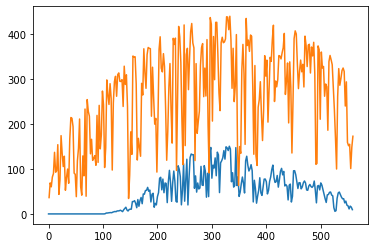

In [94]:
# 1. Persistence
#mu_pers = 
df_ts[(df_ts.date <= lTr) & (df_ts.date.dt.hour==6)]['Y'].plot()
df_ts[(df_ts.date <= lTr) & (df_ts.date.dt.hour==12)]['Y'].plot()  #[['date', 'Y']] #['Y'].shift(1)

In [ ]:
?pvlib.clearsky.dirint

In [ ]:
# 2. LASSO
lm = LassoCV()

In [19]:
?pvlib.clearsky.ineichen

In [17]:
dir(pvlib.clearsky)

['OrderedDict',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_calc_b',
 '_calc_d',
 '_calc_g',
 '_calc_i0p',
 '_calc_stats',
 '_calc_taub',
 '_calc_taud',
 '_calc_taug',
 '_calendar_month_middles',
 '_clear_sample_index',
 '_degrees_to_index',
 '_interpolate_turbidity',
 '_is_leap_year',
 '_line_length_windowed',
 '_max_diff_windowed',
 '_slope_nstd_windowed',
 '_to_centered_series',
 'atmosphere',
 'bird',
 'calendar',
 'detect_clearsky',
 'h5py',
 'hankel',
 'haurwitz',
 'ineichen',
 'lookup_linke_turbidity',
 'minimize_scalar',
 'np',
 'os',
 'pd',
 'simplified_solis',
 'tools']